Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Index(['CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age',
       'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
       'EstimatedSalary', 'Exited'],
      dtype='object')


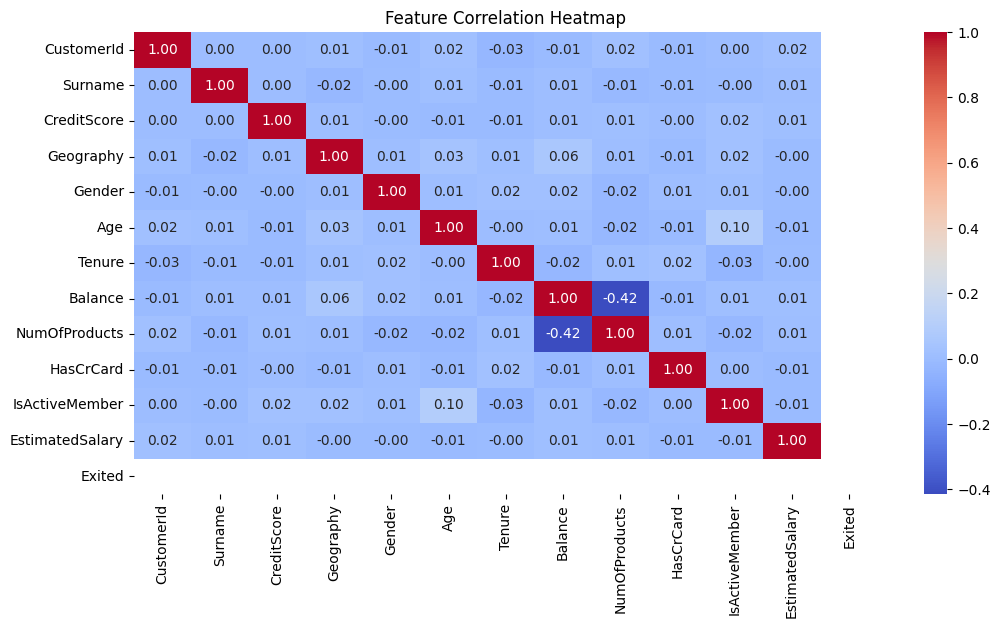

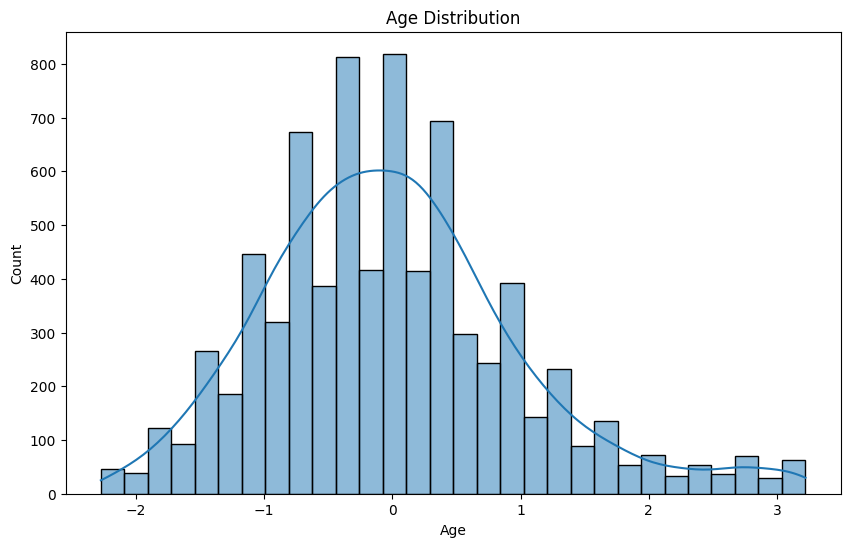

<ipython-input-19-ccd30e77b049>:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df["Exited"], y=df["Age"], palette="coolwarm")


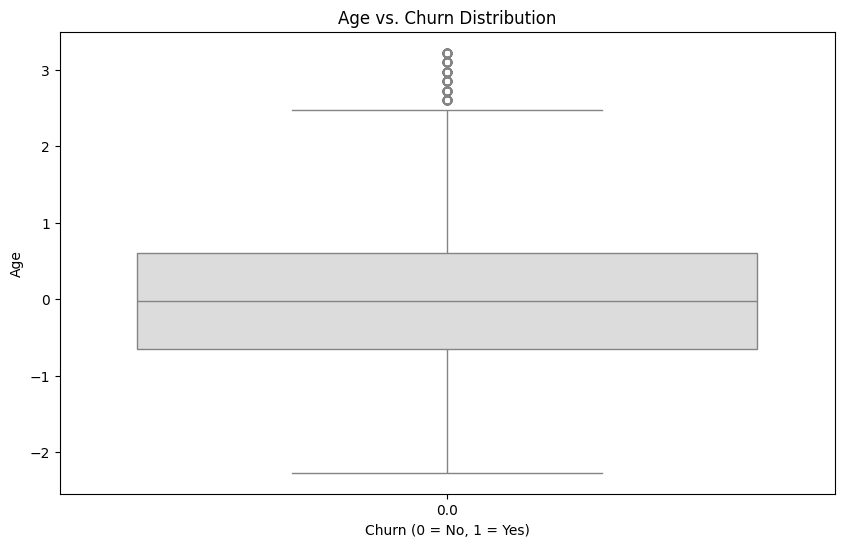

   CustomerId   Surname  CreditScore  Geography    Gender       Age    Tenure  \
1   -0.611638 -0.392953    -0.455004   1.500850 -1.158437  0.599817 -1.403186   
3    0.142704 -1.440466     0.496133  -0.865555 -1.158437  0.350214 -1.403186   
4    0.652652  0.367909     2.074392   1.500850 -1.158437  0.849420 -1.055481   
6   -1.376267 -1.572585     1.781735  -0.865555  0.863232  1.723029  0.683046   
8    1.413051 -0.429522    -1.573373  -0.865555  0.863232  0.974221 -0.360070   

    Balance  NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  \
1  0.174070      -1.072759  -1.553061        0.923583         0.221181   
3 -1.159714       0.892771  -1.553061       -1.082740        -0.104937   
4  0.837764      -1.072759   0.643890        0.923583        -0.361820   
6 -1.159714       0.892771   0.643890        0.923583        -1.564488   
8  1.100999       0.892771  -1.553061        0.923583        -0.434020   

   Exited  Prediction  
1     0.0         0.0  
3     0.0         0.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import xgboost as xgb
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')
#  Load the Dataset
dataset_path = "/content/drive/MyDrive/project/customer_churn.csv"  # Update with actual path
df = pd.read_csv(dataset_path)
#print(df.head())
print(df.columns)

#  Data Preprocessing
# Handle missing values
numeric_cols = df.select_dtypes(include=np.number).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())
# Remove duplicate rows
df.drop_duplicates(inplace=True)
# Remove highly correlated features
corr_matrix = df.select_dtypes(include=np.number).corr().abs() # Select only numeric features for correlation calculation
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]
df.drop(columns=to_drop, inplace=True)
# Encode categorical variables
le = LabelEncoder()
for col in df.select_dtypes(include=['object']).columns:
    df[col] = le.fit_transform(df[col])
df
# Handle outliers using IQR
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
df = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]
# Scale numerical features
scaler = StandardScaler()
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
scaled_features = scaler.fit_transform(df[numeric_cols])
df[numeric_cols] = scaled_features


#  Data Visualization
plt.figure(figsize=(12, 6))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(df['Age'], bins=30, kde=True)
plt.title('Age Distribution')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x=df["Exited"], y=df["Age"], palette="coolwarm")
plt.xlabel("Churn (0 = No, 1 = Yes)")
plt.ylabel("Age")
plt.title("Age vs. Churn Distribution")
plt.show()


# Splitting data into features and target
X = df.drop(columns=['Exited'])
y = df['Exited']
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Model Training
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Make predictions on the entire dataset
df['Prediction'] = model.predict(X)

# Show updated dataset with predictions
print(df.head())

# Model Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

